    Danai Zacharioudaki 9418                                           
    Stergios Grigoriou  9564                                     grigster@ece.auth.gr

In [215]:
import os
import time
from sklearn.utils.class_weight import compute_sample_weight
# import keras.constraints
import numpy as np
# import sklearn.preprocessing
from matplotlib import pyplot as plt
# from matplotlib.colors import ListedColormap
# from matplotlib.legend_handler import HandlerTuple
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import tensorflow as tf
from sklearn import svm
from sklearn import metrics as mt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.naive_bayes import GaussianNB

In [294]:
# class my_Bayes_Model:
#     #class for creating Bayes models using MLE on train data
#     def __init__(self,dif_covmat=False):
#         self.dif_covmat = dif_covmat#boolean determining if the model assumes different covariance matrix for each class or not (defaults to creating models with the same cov_matrix) 
#         self.un_labels = []#unique labels of the model
#         self.mu = []#mean values of each feature for each class label in un_labels
#         self.covmat = []#list of covariance matrices of the feature vectors 
#         self.aprior = []#apriori class probabilities
#     def train(self,features,labels):
#         #method for fitting the model to some data
#         #features are the feature vectors columnwise (2D-np.array)
#         #labels are the class labels corresponding to the features array
#         self.un_labels = np.unique(labels)
#         self.mu = [np.mean(features[labels==self.un_labels[i]],0) for i in range(len(self.un_labels))]
#         self.aprior = [np.sum(y==self.un_labels[i])/len(y) for i in range(len(self.un_labels))]
#         if self.dif_covmat:
#         #calculating the covariance matrix of the feature vectors for each class
#             self.covmat = [np.cov(features[labels==self.un_labels[i]],rowvar=False,bias=True) for i in range(len(self.un_labels))]
#         else:
#         #calculating the covariance matrix of the feature vectors
#             self.covmat = np.cov(features,rowvar=False,bias=True)
#     def predict(self,test_data):
#         #method for predicting the labels of given data
#         #test_data must have the same number of columns as the self.mu[i] vector
#         if self.dif_covmat:
#             invcov = [np.linalg.inv(self.covmat[i]) for i in range(len(self.covmat))]
#             g = np.array([[-0.5*np.transpose(test_data[j]-self.mu[i])@invcov[i]@(test_data[j]-self.mu[i]) + np.log(self.aprior[i])\
#                            for i in range(len(self.mu))] for j in range(len(test_data))])#calculating the value of each discriminant function
#         else:
#             invcov = np.linalg.inv(self.covmat)
#             g = np.array([[-0.5*np.transpose(test_data[j]-self.mu[i])@invcov@(test_data[j]-self.mu[i]) + np.log(self.aprior[i])\
#                            for i in range(len(self.mu))] for j in range(len(test_data))])#calculating the value of each discriminant function
#         y_hat = self.un_labels[np.argmax(g,1)]#estimations (max disc value)
#         return y_hat


def evaluate_model(modele,Xs,ys,model_name,label_names):
    #model is the sklearn classification model object for evaluation
    #Xs ys are the validation or test data
    #model_name is the name of the model
    #Predicting the classes of the test Xs
    t = time.time()#for calculating prediction time
    y_hat = modele.predict(Xs)
    if len(y_hat.shape) > 1:
        y_hat = np.argmax(y_hat,1)
    t = time.time() - t
    print('Prediction time elapsed: %.2f ms.' % (1000 * t))
    #Calculating recall and precision class wise
    recall = mt.recall_score(ys, y_hat, average=None)
    precision = mt.precision_score(ys, y_hat, average=None)
    # Calculating class wise f1_score
    f1 = 2*recall*precision/(recall+precision)
    #Calculating average (macro) accuracy of the model
    accu = np.sum(np.equal(ys,y_hat))/len(ys)#or just the np.mean(recall)
    print('Accuracy: %.4f'% accu)
    df = np.vstack((recall,precision))
    df = np.vstack((df,f1))
    avrgs = np.zeros((3,1))
    avrgs[2] = np.mean(f1)
    avrgs[1] = np.mean(precision)
    avrgs[0] = np.mean(recall)
    df = np.hstack((df,avrgs))
    label_names = np.hstack((label_names,'average'))
    daf = pd.DataFrame(data=df,index=['recall','precision','f1'],columns=label_names)
    print(daf.to_string())
    print('\n\n')
    #Calculating and plotting the confusion matrix of the model on the val/test data
    cm = mt.confusion_matrix(ys, y_hat)
    disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names[0:10])
    disp.plot()
    plt.title(model_name)
    plt.show()
    return recall, precision, f1

# def learning_curves(hist_obj,title_str='some model',saving=False,saving_path='',metric_name='categorical_accuracy',loss_name='cross entropy'):
#     #This function is used to plot/save the learning_curves of the various mlp models that where trained
#     #It take as input: a tf.keras.callbacks.History() object 
#     #                : the tile of the model 
#     #                : a logical value that determines if the plot will also be saved
#     #                : the saving directory 
#     #                : the name of the metric we want to plot. (must be in the list of the metrics that were calculated during the creation of the object)
#     #                : the name of the loss function we want to plot. 
#     train_lss = hist_obj.history['loss']
#     val_lss = hist_obj.history['val_loss']
#     train_metric = hist_obj.history[metric_name]
#     val_metric = hist_obj.history['val_'+metric_name]
#     epochs = np.linspace(1,len(train_lss),len(train_lss))
#     plt.plot(epochs,train_lss,label='Training')
#     plt.plot(epochs,val_lss,label='Validation')
#     plt.xlabel('epochs')
#     plt.ylabel(loss_name)
#     plt.legend()
#     plt.title('Loss curve of '+title_str)
#     if saving:
#         plt.savefig(os.path.join(saving_path,'loss_curve_of'+title_str+'.csv'))
#     plt.show()
#     plt.plot(epochs,train_metric,label='Training')
#     plt.plot(epochs,val_metric,label='Validation')
#     plt.xlabel('epochs')
#     plt.ylabel(metric_name)
#     plt.legend()
#     plt.title('Metric curve of '+title_str)
#     if saving:
#         plt.savefig(os.path.join(saving_path,'metric_curve_of'+title_str+'.csv'))
#     plt.show()
#     

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [268]:
mypath = 'C:/Users/grist/Desktop/Pattern/'#You can change this variable to the directory of the folder that contains the dataset
data = np.loadtxt(os.path.join(mypath,'datasetC.csv'), delimiter=',', dtype=np.float64)

In [269]:
X = data[:,0:400]
y = data[:,400]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=73)#Spliting the dataset into train and validation sets.

Desciptive stats of absolute pearson coefficients among fatures.
Mean correlation among features: 0.021
Max correlation among features: 0.203
Standard deviation of pearson correlation: 0.021715323211059980174075789705


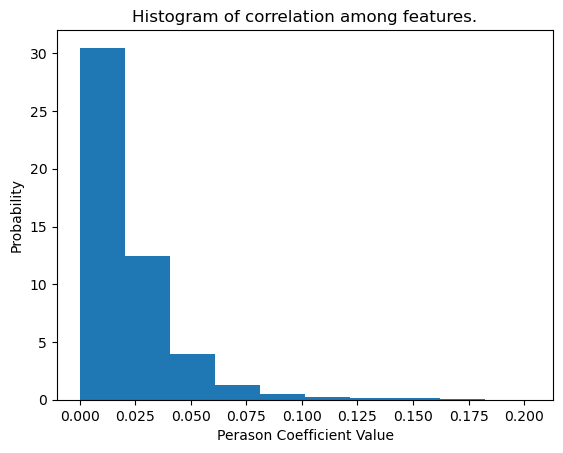

In [270]:
#Visualizing and describing feature data 
corr_matrix = np.corrcoef(X.transpose())#feature correlations
assert int(np.sum(corr_matrix[corr_matrix>0.9])) == X.shape[1]#Only the diagonal has r>0.9
mu_corr = (np.mean(np.abs(corr_matrix[corr_matrix<0.9])))
max_corr = (np.max(np.abs(corr_matrix[corr_matrix<0.9])))
std_corr = np.std(np.abs((corr_matrix[corr_matrix<0.9])))
print('Desciptive stats of absolute pearson coefficients among fatures.\nMean correlation among features: %.3f\nMax correlation among features: %.3f'%(mu_corr,max_corr))
print('Standard deviation of pearson correlation: %.30f'% std_corr)
plt.hist(np.abs(corr_matrix[corr_matrix<0.9]),10,density= True)
plt.title('Histogram of correlation among features.')
plt.xlabel('Perason Coefficient Value')
plt.ylabel('Probability')
plt.show()

The inverse class frequencies are:
[0.88573959 0.96711799 1.00806452 1.01936799 1.15740741]
Out of 400 features at 95% significance level, 120 cannnot be considered Gaussian.
The farthest from gaussian feature is ploted.


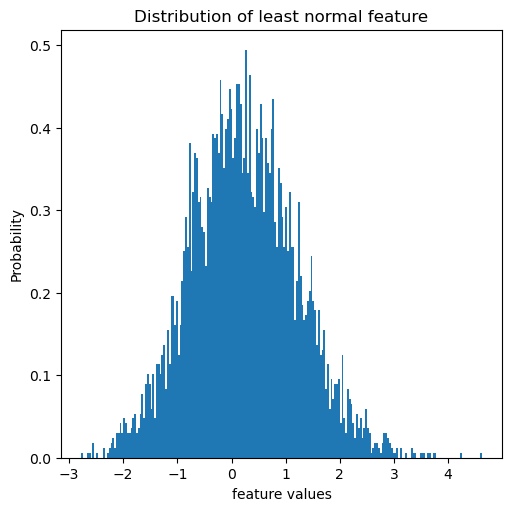

In [281]:
#Dealing with outliers
class_weights = compute_sample_weight('balanced', y)
scaler = StandardScaler()#scaling data
X_s = scaler.fit_transform(X)
print('The inverse class frequencies are:')
print(np.unique(class_weights))
pca = PCA(n_components=400)
X_pca = pca.fit_transform(X_s)
X_back = pca.inverse_transform(X_pca)
rec_errors = np.linalg.norm(X_pca - X_back, axis=1)
threshold_pca = np.percentile(rec_errors, 99)#discarding 1% of the sample 
outliers_pca = X[rec_errors > threshold_pca]
sw_stat = np.zeros((400,))
X_wo = X_s[rec_errors<threshold_pca]
#Testing for gaussianity
p_val = sw_stat
for i in range(len(sw_stat)):
    sw_stat[i], p_val[i] = stats.shapiro(X_wo[:, i])
#sw_stat and p_val are the same
print('Out of 400 features at 95%% significance level, %d cannnot be considered Gaussian.' % int(
    np.sum((sw_stat < 0.05))))
print('The farthest from gaussian feature is ploted.')
figS,axS = plt.subplots(1,1,layout='constrained',figsize=(5,5))
plt.hist(X[:,int(np.argmin(p_val))],220,density=True)
plt.title('Distribution of least normal feature')
plt.xlabel('feature values')
plt.ylabel('Probability')
plt.show()

In [290]:
# Training and evaluating the 3 best classifiers (that resulted from the commented code below)
rbfSVM = svm.SVC(kernel='rbf',C = 8,gamma=2.0**(-8),class_weight='balanced',random_state=73)
gnb = GaussianNB()
skf = StratifiedKFold(shuffle=True,random_state=73,n_splits=5)
acc_SVM = np.zeros((5,))
acc_same = np.zeros((5,))
pca1= PCA(0.5)
X_pca = pca1.fit_transform(X_wo)
y_wo = y[rec_errors < threshold_pca]
for i, (train_index, test_index) in enumerate(skf.split(X_pca, y_wo)):
    rbfSVM.fit(X_pca[train_index],y_wo[train_index])
    y_SVM = rbfSVM.predict(X_pca[test_index])
    corr_class_svm = y_SVM == y_wo[test_index]
    acc_SVM[i] = np.sum(corr_class_svm)/len(y_wo[test_index])
    gnb.fit(X_pca[train_index],y_wo[train_index])
    y_ss = gnb.predict(X_pca[test_index])
    corr_class_ss = y_ss == y_wo[test_index]
    acc_same[i] = np.sum(corr_class_ss)/len(y_wo[test_index])

In [291]:
print('SVM 5-fold cross validation mean acurracy: %.2f %%'%(np.mean(acc_SVM)*100))
print('Naive Bayes 5-fold cross validation mean acurracy: %.2f %%'%(np.mean(acc_same)*100))

SVM 5-fold cross validation mean acurracy: 86.26 %
Naive Bayes 5-fold cross validation mean acurracy: 82.04 %


Prediction time elapsed: 1046.45 ms.
Accuracy: 0.8490
                  1         2         3         4         5   average
recall     0.938053  0.839623  0.788732  0.875598  0.788889  0.846179
precision  0.887029  0.839623  0.803828  0.901478  0.802260  0.846843
f1         0.911828  0.839623  0.796209  0.888350  0.795518  0.846305


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (6).

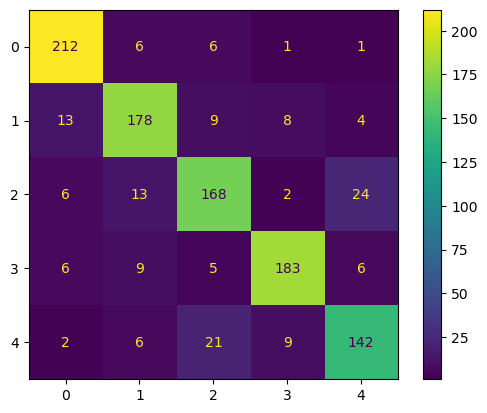

In [297]:
#Fitting on the last fold (it was the worst for the SVM with 85% and evaluating on all rest X even the "outliers" to get a worst case scenario estimation)
Xtest = np.concatenate((X_pca[test_index],pca1.transform(X_s)[rec_errors > threshold_pca]),axis=0)
ytest = np.concatenate((y_wo[test_index],y[rec_errors > threshold_pca]),axis=0)
_,_,_ = evaluate_model(rbfSVM,Xtest,ytest,'Best classifier',['1','2','3','4','5'])

In [301]:
X_test = np.loadtxt(os.path.join(mypath,'datasetCTest.csv'), delimiter=',', dtype=np.float64)
X_test = pca1.transform(X_test)
labels1 = rbfSVM.predict(X_test)
np.save(os.path.join(mypath,'labels1.npy'),labels1)

The code below is a summary of the tests performed. For some cells multiple instances were run.
(Eg with or without discarding outliers/scaled-unscaled data and so on)

In [26]:
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
# pipe = Pipeline(
#     [
#         ("scaling", StandardScaler()),
#         # the reduce_dim stage is populated by the param_grid
#         ("reduce_dim", "passthrough"),
#         ("classify", svm.SVC(kernel='rbf',cache_size=1000)),
#     ]
# )
# Cval = 2.0**np.arange(start=-5,stop=17,step=2)
# gammaval = 2.0**np.arange(start=-15,stop=5,step=0.25)
# var_explained = [PCA(0.8),PCA(0.95),None]
# params = {
#         "reduce_dim": var_explained,
#         "classify__C": Cval,
#         "classify__gamma": gammaval
#     }

In [29]:
# CVRBF_ALL = GridSearchCV(pipe,params,scoring='accuracy',verbose=300,n_jobs=-1)
# CVRBF_ALL.fit(X,y)

Fitting 5 folds for each of 2640 candidates, totalling 13200 fits


GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', SVC(cache_size=1000))]),
             n_jobs=-1,
             param_grid={'classify__C': array([3.1250e-02, 1.2500e-01, 5.0000e-01, 2.0000e+00, 8.0000e+00,
       3.2000e+01, 1.2800e+02, 5.1200e+02, 2.0480e+03, 8.1920e+03,
       3.2768e+04]),
                         'classify__gamma': array([3.05175781e-05, 3.62917210e...
       1.00000000e+00, 1.18920712e+00, 1.41421356e+00, 1.68179283e+00,
       2.00000000e+00, 2.37841423e+00, 2.82842712e+00, 3.36358566e+00,
       4.00000000e+00, 4.75682846e+00, 5.65685425e+00, 6.72717132e+00,
       8.00000000e+00, 9.51365692e+00, 1.13137085e+01, 1.34543426e+01,
       1.60000000e+01, 1.90273138e+01, 2.26274170e+01, 2.69086853e+01]),
                         'reduce_dim': [PCA(n_components=0.8),
                                        PCA(n_components=0.95), None]},
             scoring='accuracy', verbose=300)

In [30]:
# from pandas import DataFrame as df
# cv_rbf_all = df(CVRBF_ALL.cv_results_)
# cv_rbf_all

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__gamma,param_reduce_dim,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.246612,0.150187,3.151574,0.059293,0.03125,0.000031,PCA(n_components=0.8),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
1,21.652306,0.720111,4.333413,0.091488,0.03125,0.000031,PCA(n_components=0.95),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2,23.178026,0.275668,4.652960,0.192761,0.03125,0.000031,None,"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
3,18.004459,0.345813,3.379173,0.121815,0.03125,0.000036,PCA(n_components=0.8),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
4,22.624651,2.117411,5.206100,0.693719,0.03125,0.000036,PCA(n_components=0.95),"{'classify__C': 0.03125, 'classify__gamma': 3....",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,26.853995,0.431838,5.382788,0.233106,32768.0,22.627417,PCA(n_components=0.95),"{'classify__C': 32768.0, 'classify__gamma': 22...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2636,27.873748,0.455026,6.062863,0.313304,32768.0,22.627417,None,"{'classify__C': 32768.0, 'classify__gamma': 22...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2637,23.174534,0.295614,4.305100,0.231649,32768.0,26.908685,PCA(n_components=0.8),"{'classify__C': 32768.0, 'classify__gamma': 26...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091
2638,27.321843,0.469695,5.412551,0.181543,32768.0,26.908685,PCA(n_components=0.95),"{'classify__C': 32768.0, 'classify__gamma': 26...",0.226,0.226,0.226,0.226,0.225,0.2258,0.0004,1091


In [55]:
# pipe2 = Pipeline(
#     [
#         ("reduce_dim", PCA(0.8)),
#         ("classify", svm.SVC(kernel='rbf',cache_size=1000,class_weight='balanced')),
#     ]
# )
# Cbest = 8
# gammabest = 2.0**(-8)
# param_grid_best = {
#         "classify__C": [Cbest],
#         "classify__gamma": [gammabest]
#     }
# cvrbf = GridSearchCV(pipe2,param_grid_best,scoring='accuracy',verbose=300,n_jobs=-1)

In [56]:
# cvrbf.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', PCA(n_components=0.8)),
                                       ('classify',
                                        SVC(cache_size=1000,
                                            class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'classify__C': [8], 'classify__gamma': [0.00390625]},
             scoring='accuracy', verbose=300)

In [57]:
# cv_rbf = df(cvrbf.cv_results_)
# cv_rbf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.124289,0.204356,1.488227,0.071093,8,0.003906,"{'classify__C': 8, 'classify__gamma': 0.00390625}",0.837,0.866,0.861,0.83,0.86,0.8508,0.014442,1


In [53]:
# skf = StratifiedKFold(shuffle=True,random_state=73,n_splits=5)
# acc_diff = np.zeros((5,))
# acc_same = np.zeros((5,))
# for i, (train_index, test_index) in enumerate(skf.split(X, y)):
#     model= my_Bayes_Model(True)
#     model_s = my_Bayes_Model()
#     model.train(X[train_index],y[train_index])
#     model_s.train(X[train_index],y[train_index])
#     y_diff = model.predict(X[test_index])
#     corr_class_diff = y_diff == y[test_index]
#     acc_diff[i] = np.sum(corr_class_diff)/len(y[test_index])
#     y_s = model_s.predict(X[test_index])
#     corr_class_s = y_s == y[test_index]
#     acc_same[i] = np.sum(corr_class_s)/len(y[test_index])

In [58]:
# print(acc_diff)
# print(acc_same)
# print(np.mean(acc_same))

[0.447 0.469 0.451 0.45  0.448]
[0.792 0.815 0.786 0.811 0.8  ]
0.8008


In [75]:
# param_grid_best_iter = {
#         "classify__C": [Cbest],
#         "classify__gamma": [gammabest],
#         "classify__max_iter": [250,750,1500,2000],
#         "reduce_dim":[PCA(0.8)]
#     }
# cvrbfiter = GridSearchCV(pipe,param_grid_best_iter,scoring='accuracy',verbose=300,n_jobs=-1)

In [76]:
# cvrbfiter.fit(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=750).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', SVC(cache_size=1000))]),
             n_jobs=-1,
             param_grid={'classify__C': [8], 'classify__gamma': [0.00390625],
                         'classify__max_iter': [250, 750, 1500, 2000],
                         'reduce_dim': [PCA(n_components=0.8)]},
             scoring='accuracy', verbose=300)

In [77]:
# cv_rbfiter = df(cvrbfiter.cv_results_)
# cv_rbfiter

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__C,param_classify__gamma,param_classify__max_iter,param_reduce_dim,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.713693,0.148862,1.679230,0.015322,8,0.003906,250,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.832,0.859,0.860,0.823,0.847,0.8442,0.014662,4
1,11.285786,0.351078,2.706060,0.115389,8,0.003906,750,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.837,0.870,0.860,0.832,0.857,0.8512,0.014386,1
2,11.939843,0.200933,2.695863,0.202519,8,0.003906,1500,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.838,0.869,0.857,0.829,0.857,0.8500,0.014450,3
3,11.134272,1.366832,1.459421,0.307775,8,0.003906,2000,PCA(n_components=0.8),"{'classify__C': 8, 'classify__gamma': 0.003906...",0.838,0.869,0.857,0.829,0.858,0.8502,0.014552,2


In [90]:
# from sklearn.neighbors import KNeighborsClassifier as knn
# pipe1 =Pipeline([('s',StandardScaler()),('pca','passthrough'),('clf',knn())])
# knn_params = {'pca':[PCA(0.8),None],'clf__n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
# cvknn = GridSearchCV(pipe1,knn_params,scoring='accuracy',n_jobs=-1)

In [91]:
# cvknn.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('s', StandardScaler()),
                                       ('pca', 'passthrough'),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16],
                         'pca': [PCA(n_components=0.8), None]},
             scoring='accuracy')

In [92]:
# cv_knn = df(cvknn.cv_results_)
# cv_knn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_neighbors,param_pca,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.154041,0.042697,0.239397,0.034305,1,PCA(n_components=0.8),"{'clf__n_neighbors': 1, 'pca': PCA(n_component...",0.629,0.659,0.650,0.633,0.661,0.6464,0.013170,29
1,0.112903,0.007693,0.376605,0.042067,1,None,"{'clf__n_neighbors': 1, 'pca': None}",0.611,0.646,0.598,0.595,0.646,0.6192,0.022534,30
2,1.056366,0.223805,0.273854,0.043442,2,PCA(n_components=0.8),"{'clf__n_neighbors': 2, 'pca': PCA(n_component...",0.614,0.630,0.619,0.588,0.615,0.6132,0.013819,31
3,0.110198,0.020118,0.357996,0.125453,2,None,"{'clf__n_neighbors': 2, 'pca': None}",0.590,0.612,0.603,0.583,0.608,0.5992,0.010980,32
4,1.130348,0.134228,0.245649,0.032373,3,PCA(n_components=0.8),"{'clf__n_neighbors': 3, 'pca': PCA(n_component...",0.664,0.679,0.682,0.646,0.679,0.6700,0.013550,27
5,0.130889,0.068231,0.293945,0.039632,3,None,"{'clf__n_neighbors': 3, 'pca': None}",0.632,0.678,0.659,0.637,0.659,0.6530,0.016697,28
6,0.972327,0.079514,0.210950,0.008251,4,PCA(n_components=0.8),"{'clf__n_neighbors': 4, 'pca': PCA(n_component...",0.669,0.705,0.716,0.668,0.711,0.6938,0.020951,25
7,0.117552,0.012294,0.307077,0.039598,4,None,"{'clf__n_neighbors': 4, 'pca': None}",0.659,0.701,0.697,0.654,0.704,0.6830,0.021808,26
8,0.924222,0.036404,0.224722,0.014144,5,PCA(n_components=0.8),"{'clf__n_neighbors': 5, 'pca': PCA(n_component...",0.682,0.710,0.715,0.663,0.722,0.6984,0.022312,22
9,0.113215,0.005722,0.299362,0.013423,5,None,"{'clf__n_neighbors': 5, 'pca': None}",0.673,0.726,0.710,0.658,0.706,0.6946,0.025136,24


In [178]:
# mlp = tf.keras.Sequential()
# mlp.add(tf.keras.layers.InputLayer(400,))
# # mlp.add(tf.keras.layers.BatchNormalization())
# mlp.add(tf.keras.layers.Dense(1200,activation='relu'))
# mlp.add(tf.keras.layers.Dense(600,activation='relu'))
# mlp.add(tf.keras.layers.Dense(300,activation='relu'))
# mlp.add(tf.keras.layers.Dense(5,activation='softmax'))
# mlp.compile(optimizer=tf.keras.optimizers.experimental.SGD(clipnorm=1,learning_rate=0.0008),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['categorical_accuracy'])
# history = mlp.fit(X_wo, y_one_hot[rec_errors<threshold_pca], batch_size=40, epochs=50, validation_split=0.2,verbose=2)

Epoch 1/50
99/99 - 2s - loss: 1.2913 - categorical_accuracy: 0.1962 - val_loss: 1.2504 - val_categorical_accuracy: 0.2202 - 2s/epoch - 21ms/step
Epoch 2/50
99/99 - 1s - loss: 1.2091 - categorical_accuracy: 0.2460 - val_loss: 1.1979 - val_categorical_accuracy: 0.2556 - 533ms/epoch - 5ms/step
Epoch 3/50
99/99 - 1s - loss: 1.1618 - categorical_accuracy: 0.2848 - val_loss: 1.1592 - val_categorical_accuracy: 0.2828 - 507ms/epoch - 5ms/step
Epoch 4/50
99/99 - 1s - loss: 1.1240 - categorical_accuracy: 0.3290 - val_loss: 1.1263 - val_categorical_accuracy: 0.3273 - 503ms/epoch - 5ms/step
Epoch 5/50
99/99 - 1s - loss: 1.0904 - categorical_accuracy: 0.3755 - val_loss: 1.0948 - val_categorical_accuracy: 0.3697 - 505ms/epoch - 5ms/step
Epoch 6/50
99/99 - 1s - loss: 1.0589 - categorical_accuracy: 0.4205 - val_loss: 1.0652 - val_categorical_accuracy: 0.4010 - 513ms/epoch - 5ms/step
Epoch 7/50
99/99 - 1s - loss: 1.0282 - categorical_accuracy: 0.4505 - val_loss: 1.0360 - val_categorical_accuracy: 0.442

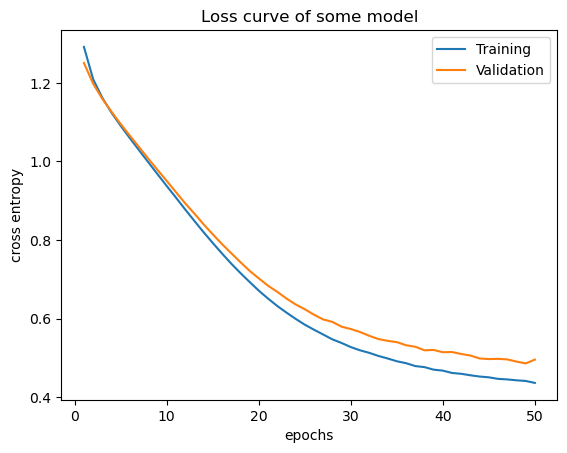

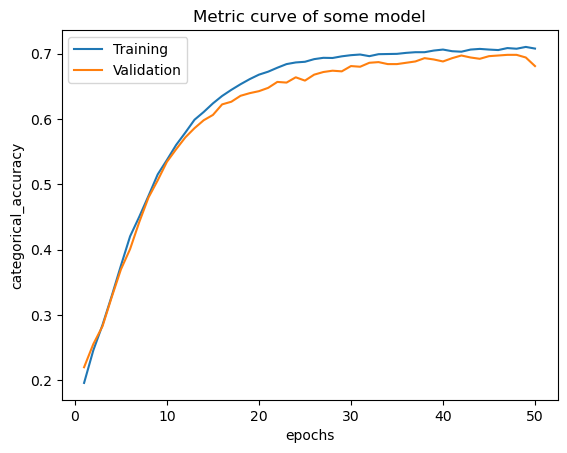

In [179]:
# learning_curves(history)

In [180]:
# mlp.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 1200)              481200    
                                                                 
 dense_117 (Dense)           (None, 600)               720600    
                                                                 
 dense_118 (Dense)           (None, 300)               180300    
                                                                 
 dense_119 (Dense)           (None, 5)                 1505      
                                                                 
Total params: 1,383,605
Trainable params: 1,383,605
Non-trainable params: 0
_________________________________________________________________


C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\grist\anaconda3\envs\ml_nn\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

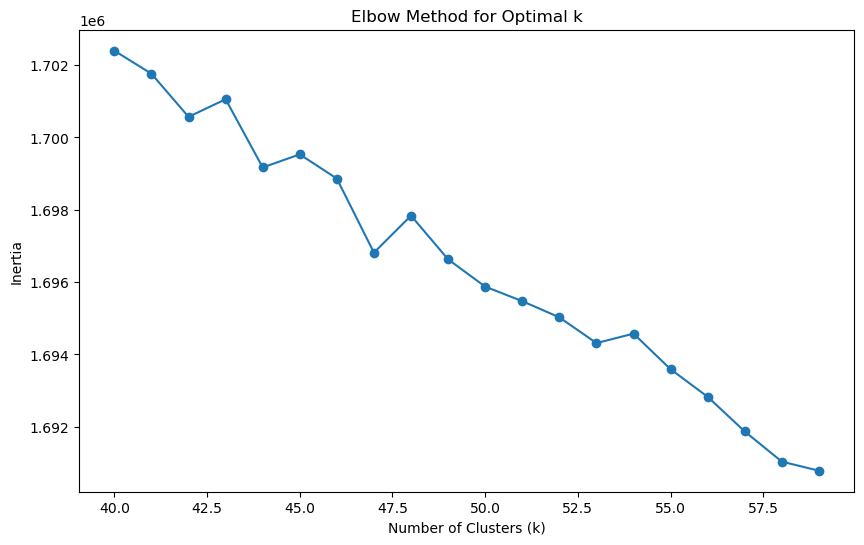

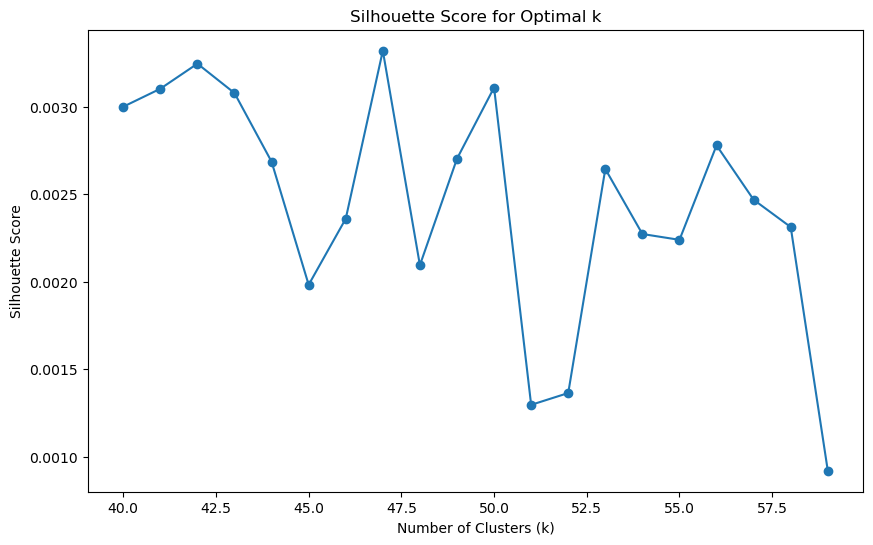

In [190]:
# from sklearn.cluster import KMeans 
# from sklearn.metrics import silhouette_score
# 
# K_range = np.arange(start=40,step=1,stop=60)
# silhouette_scores = []
# distortions = []
# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_wo)
# 
#     distortions.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(X_wo, kmeans.labels_))
# 
# # Plot the elbow curve
# plt.figure(figsize=(10, 6))
# plt.plot(K_range, distortions, marker='o')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.show()
# 
# # Plot silhouette scores
# plt.figure(figsize=(10, 6))
# plt.plot(K_range, silhouette_scores, marker='o')
# plt.title('Silhouette Score for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.show()

In [202]:
# skf = StratifiedKFold(shuffle=True,random_state=73,n_splits=5)
# acc_diffs = np.zeros((5,))
# acc_sames = np.zeros((5,))
# pca= PCA(0.8)
# X_wo = pca.fit_transform(X)
# y_wo = y
# for i, (train_index, test_index) in enumerate(skf.split(X_wo, y_wo)):
#     models= my_Bayes_Model(True)
#     model_ss = my_Bayes_Model()
#     models.train(X_wo[train_index],y_wo[train_index])
#     model_ss.train(X_wo[train_index],y_wo[train_index])
#     y_diffs = models.predict(X_wo[test_index])
#     corr_class_diffs = y_diffs == y_wo[test_index]
#     acc_diffs[i] = np.sum(corr_class_diffs)/len(y_wo[test_index])
#     y_ss = model_ss.predict(X_wo[test_index])
#     corr_class_ss = y_ss == y_wo[test_index]
#     acc_sames[i] = np.sum(corr_class_ss)/len(y_wo[test_index])

In [203]:
# print(acc_diffs)
# print(acc_sames)
# print(np.mean(acc_sames))

[0.58  0.571 0.579 0.569 0.563]
[0.815 0.822 0.789 0.817 0.802]
0.8089999999999999
